# Sentiment Analysis

This notebook researches one aspect of technical analysis, namely the relationship between
the sentiment of the posts regarding cryptocurrencies with their volume and prices.

### Loading dependencies

In [1]:
import nltk
from tqdm import tqdm

nltk.download('vader_lexicon')  # for sentiment analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\barto\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Quick Demo of  Sentiment Analysis using VADER

**VADER** (Valence Aware Dictionary for sEntiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.
It is available in the NLTK package. VADER will not only detect the positiveness/negativess of a word like "love", "like", "enjoy", "hate", but also it is intelligent enough to understand the context of these words such as "did not like" as negative. Also it understands capitalisation and punctuation.

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
# Example usage
a = "This was the BEST movie ever!"
print(sid.polarity_scores(a))

b = "Worst movie I've seen."
print(sid.polarity_scores(b))



{'neg': 0.0, 'neu': 0.489, 'pos': 0.511, 'compound': 0.7371}
{'neg': 0.577, 'neu': 0.423, 'pos': 0.0, 'compound': -0.6249}


### Sentiment Analysis on Bitcoin Posts data

### Loading crypto posts

In [3]:
import pandas as pd
import os

DATA_DIR = 'data'
bitcoin_posts = pd.read_xml(os.path.join(os.getcwd(), DATA_DIR, 'bitcoin.stackexchange.com-20240119T151759Z-001', 'bitcoin.stackexchange.com', 'Posts.xml'))
cardano_posts = pd.read_xml(os.path.join(os.getcwd(), DATA_DIR, 'cardano.stackexchange.com-20240119T140405Z-001','cardano.stackexchange.com', 'Posts.xml'))
ethereum_posts = pd.read_xml(os.path.join(os.getcwd(), DATA_DIR, 'ethereum.stackexchange.com-20240119T140954Z-001', 'ethereum.stackexchange.com', 'Posts.xml'))
solana_posts = pd.read_xml(os.path.join(os.getcwd(), DATA_DIR, 'solana.stackexchange.com-20240119T141009Z-001', 'solana.stackexchange.com', 'Posts.xml'))

In [4]:
# choose only some (common) columns
columns = [
    'Id',
    'PostTypeId',
    'AcceptedAnswerId',
    'ParentId',
    'CreationDate',
    'Score',
    'ViewCount',
    'Body',
    'OwnerUserId',
    'OwnerDisplayName',
    'LastEditorUserId',
    'LastEditDate',
    'LastActivityDate',
    'Title',
    'Tags',
    'AnswerCount',
    'CommentCount',
    'FavoriteCount',
    'ClosedDate',
    'CommunityOwnedDate',
    'ContentLicense'
]

bitcoin_posts = bitcoin_posts[columns]
cardano_posts = cardano_posts[columns]
ethereum_posts = ethereum_posts[columns]
solana_posts = solana_posts[columns]

In [5]:
# merge
bitcoin_posts = bitcoin_posts.assign(Source='bitcoin')
cardano_posts = cardano_posts.assign(Source='cardano')
ethereum_posts = ethereum_posts.assign(Source='ethereum')
solana_posts = solana_posts.assign(Source='solana')
crypto_posts = pd.concat([bitcoin_posts, cardano_posts, ethereum_posts, solana_posts], ignore_index=True)

# Remove variables from memory
del bitcoin_posts, cardano_posts, ethereum_posts, solana_posts

### Loading crypto price history

In [6]:
# load historical prices
bitcoin_prices = pd.read_csv("historical_prices/bitcoin_data.csv")
cardano_prices = pd.read_csv("historical_prices/ADA-USD.csv")
ethereum_prices = pd.read_csv("historical_prices/ETH-USD.csv")
solana_prices = pd.read_csv("historical_prices/SOL-USD.csv")

In [7]:
#  specify date type for time-series analysis, ignore timezone info
bitcoin_prices["Date"] = pd.to_datetime(bitcoin_prices["Time"]).dt.tz_localize(None)
bitcoin_prices.drop(columns=["Time"], inplace=True)
cardano_prices["Date"] = pd.to_datetime(cardano_prices["Date"]).dt.tz_localize(None)
ethereum_prices["Date"] = pd.to_datetime(ethereum_prices["Date"]).dt.tz_localize(None)
solana_prices["Date"] = pd.to_datetime(solana_prices["Date"]).dt.tz_localize(None)

Bitcoin has a single price while other dataframes have multiple columns for price.
We'll use 

In [8]:
# examine the common data range for all dataframes
min_date = min([bitcoin_prices["Date"].min(),
           cardano_prices["Date"].min(),
           ethereum_prices["Date"].min(),
           solana_prices["Date"].min()])
max_date = max([bitcoin_prices["Date"].max(),
           cardano_prices["Date"].max(),
           ethereum_prices["Date"].max(),
           solana_prices["Date"].max()])
print(f"Common date range is from {min_date} to {max_date}")

Common date range is from 2010-07-17 00:00:00 to 2024-01-27 00:00:00


In [9]:
# filter the dataframes to the common date range
def filter_by_date(df, min_date, max_date):
    return df[(df["Date"] >= min_date) & (df["Date"] <= max_date)]

bitcoin_prices = filter_by_date(bitcoin_prices, min_date, max_date)
cardano_prices = filter_by_date(cardano_prices, min_date, max_date)
ethereum_prices = filter_by_date(ethereum_prices, min_date, max_date)
solana_prices = filter_by_date(solana_prices, min_date, max_date)

In [10]:
# for cardano, ethereum, solana, specify price and remove the rest of the cols
cardano_prices["price"] = cardano_prices["Close"]
cardano_prices["volume"] = cardano_prices["Volume"]
ethereum_prices["price"] = ethereum_prices["Close"]
ethereum_prices["volume"] = ethereum_prices["Volume"]
solana_prices["price"] = solana_prices["Close"]
solana_prices["volume"] = solana_prices["Volume"]
# select cols of interest
cols = ["Date", "price", "volume"]
cardano_prices = cardano_prices[cols]
ethereum_prices = ethereum_prices[cols]
solana_prices = solana_prices[cols]

In [11]:
# finally merge the dataframes into one, and specify source
bitcoin_prices = bitcoin_prices.assign(Source='bitcoin')
cardano_prices = cardano_prices.assign(Source='cardano')
ethereum_prices = ethereum_prices.assign(Source='ethereum')
solana_prices = solana_prices.assign(Source='solana')
crypto_prices = pd.concat([bitcoin_prices, cardano_prices, ethereum_prices, solana_prices], ignore_index=True)

# Remove unused dfs
del bitcoin_prices, cardano_prices, ethereum_prices, solana_prices

In [12]:
# crypto prices and volume for four cryptocurrencies per date in the specified date range
crypto_prices.head()

price     volume       Date   Source
0  0.049510   0.990200 2010-07-17  bitcoin
1  0.077975   5.091994 2010-07-18  bitcoin
2  0.086792  49.731775 2010-07-19  bitcoin
3  0.077999  20.595480 2010-07-20  bitcoin
4  0.070463  42.554942 2010-07-21  bitcoin

### Sentiment analysis on posts

In [13]:
def compute_polarity(text: str|None, prefix: str="", suffix: str=""):
    result = {f"{prefix}neg{suffix}": None,
              f"{prefix}neu{suffix}": None,
              f"{prefix}pos{suffix}": None,
              f"{prefix}compound{suffix}": None}
    if pd.isna(text):
        return result
    result_json = {f"{prefix}{key}{suffix}": value for key, value in sid.polarity_scores(text).items()}
    return result_json

In [14]:
import numpy as np
# vectorize function for performance
compute_polarity_vec = np.vectorize(compute_polarity)

In [15]:
# apply sentiment analysis to the title (this may take a while)
tqdm.pandas(desc="Applying VADER Sentiment Intensity analysis for Title")
crypto_posts["title_vader"] = crypto_posts["Title"].progress_apply(compute_polarity_vec, prefix="title_")

Applying VADER Sentiment Intensity analysis for Title:   0%|          | 0/200980 [00:00<?, ?it/s]

Applying VADER Sentiment Intensity analysis for Title: 100%|██████████| 200980/200980 [00:18<00:00, 11042.38it/s]


In [16]:
# apply sentiment analysis to the body (this may take a longer while, ~5min)
tqdm.pandas(desc="Applying VADER Sentiment Intensity analysis for Title")
crypto_posts["body_vader"] = crypto_posts["Body"].progress_apply(compute_polarity_vec, prefix="body_")

Applying VADER Sentiment Intensity analysis for Title: 100%|██████████| 200980/200980 [04:45<00:00, 704.94it/s]


In [18]:
# normalize the json columns
crypto_posts = pd.concat([crypto_posts, 
                          pd.json_normalize(crypto_posts["title_vader"]),
                          pd.json_normalize(crypto_posts["body_vader"])], axis=1)
# remove duplicated-info columns
crypto_posts = crypto_posts.drop(columns=["title_vader", "body_vader"])

In [23]:
# make CreationDate a datetime object and remove timezone info
crypto_posts["Date"] = pd.to_datetime(crypto_posts["CreationDate"]).dt.tz_localize(None)
# strip of time info
crypto_posts["Date"] = crypto_posts["Date"].dt.date

In [26]:
# group by Date (without time) and Source, and aggregate 'title_neg', 'title_neu', 'title_pos', 'title_compound', 
# 'body_neg', 'body_neu', 'body_pos', 'body_compound'
plot_info = crypto_posts.groupby(["Date", "Source"]).agg({
    "title_neg": "mean",
    "title_neu": "mean",
    "title_pos": "mean",
    "title_compound": "mean",
    "body_neg": "mean",
    "body_neu": "mean",
    "body_pos": "mean",
    "body_compound": "mean"
}).reset_index()
plot_info.head()

Date   Source  title_neg  title_neu  title_pos  title_compound  \
0  2011-08-30  bitcoin   0.059936   0.843830   0.096234        0.043228   
1  2011-08-31  bitcoin   0.016417   0.938229   0.045354        0.064429   
2  2011-09-01  bitcoin   0.043273   0.813318   0.143455        0.176805   
3  2011-09-02  bitcoin   0.050111   0.883278   0.066611       -0.004789   
4  2011-09-03  bitcoin   0.039778   0.868667   0.091556        0.070383   

   body_neg  body_neu  body_pos  body_compound  
0  0.045380  0.863772  0.090899       0.263146  
1  0.041107  0.884638  0.074295       0.183644  
2  0.044377  0.873961  0.081597       0.298190  
3  0.040508  0.882600  0.076815       0.310378  
4  0.065963  0.871389  0.062741       0.078898

In [74]:
import pandas as pd
import plotly.graph_objects as go

# Apply moving average to the positive sentiment
plot_info['smoothed_pos'] = plot_info.groupby('Source')['body_pos']\
                                     .rolling(window=10, min_periods=1)\
                                     .mean().reset_index(level=0, drop=True)

# Apply moving average to the negative sentiment
plot_info['smoothed_neu'] = plot_info.groupby('Source')['body_neu']\
                                     .rolling(window=10, min_periods=1)\
                                     .mean().reset_index(level=0, drop=True)

# Create a new figure
fig = go.Figure()

# Add the positive sentiment line
fig.add_trace(go.Scatter(x=plot_info['Date'], y=plot_info['smoothed_pos'], 
                         mode='lines', name='Positive', line=dict(color='green')))
# Add the negative sentiment line
fig.add_trace(go.Scatter(x=plot_info['Date'], y=plot_info['smoothed_neg'], 
                         mode='lines', name='Negative', line=dict(color='red')))

# Show the figure
fig.update_layout(title_text="Smoothed (10D) pos/neg score over time")
fig.show()

In [79]:
# count the sentiment class by idenfifying which score that is the largest
score_counts = crypto_posts[['title_neg', 'title_neu', 'title_pos']].idxmax(axis=1).value_counts()
# rename the labels
label_mapping = {'title_neg': 'Negative', 'title_neu': 'Neutral', 'title_pos': 'Positive'}
score_counts.index = score_counts.index.map(label_mapping)

# percentage
score_percentages = score_counts / score_counts.sum() * 100

# pie chart
fig = go.Figure(data=[go.Pie(labels=score_counts.index, values=score_counts.values, hole=.3)])
fig.update_traces(textinfo='percent+label')
fig.update_layout(title_text="Title Sentiment class distribution")
fig.show()


C:\Users\barto\AppData\Local\Temp\ipykernel_17880\3953495413.py:2: FutureWarning:

The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError



In [68]:
import plotly.express as px

# Positive sentiment
plot_info['smoothed_pos'] = plot_info.groupby('Source')['body_pos']\
                                     .rolling(window=10, min_periods=1)\
                                     .mean().reset_index(level=0, drop=True)

fig = px.line(plot_info, x='Date', y='smoothed_pos', color='Source',
              title="Smoothed Positive Score for Crypto")
fig.show()

# Negative sentiment
plot_info['smoothed_neg'] = plot_info.groupby('Source')['body_neg']\
                                     .rolling(window=10, min_periods=1)\
                                     .mean().reset_index(level=0, drop=True)

fig = px.line(plot_info, x='Date', y='smoothed_pos', color='Source',
              title="Smoothed Negative Score for Crypto)
fig.show()

In [66]:
import pandas as pd
# positive sentiment
import plotly.express as px

# Apply moving average to the compound sentiment
plot_info['smoothed_compound'] = plot_info.groupby('Source')['body_compound'].rolling(window=10, min_periods=1).mean().reset_index(level=0, drop=True)

# Plot the smoothed compound sentiment
fig = px.line(plot_info, x='Date', y='smoothed_compound', color='Source', 
              title='Smoothed (10-D) Compound Sentiment (Post Body) per cryptocurrency')
fig.show()

In [80]:
import plotly.express as px

# Apply moving average to the smoothed compound change
plot_info['smoothed_compound_change'] = plot_info.groupby('Source')['smoothed_compound'].diff().rolling(window=10, min_periods=1).mean()

# Create a figure
fig = px.line(plot_info[plot_info["Source"]=="bitcoin"], x='Date', y='smoothed_compound_change', 
              title='Smoothed Compound Change vs Price Change')

# Add the price change to the figure
fig.add_scatter(x=crypto_prices['Date'], 
                y=crypto_prices.groupby('Source')['price'].pct_change().rolling(window=10, min_periods=1).mean(), 
                mode='lines', 
                name='Smoothed Price Change')

# Show the figure
fig.show()


In [60]:
crypto_posts['Date'] = pd.to_datetime(crypto_posts['Date'])
crypto_prices['Date'] = pd.to_datetime(crypto_prices['Date'])

# merge
merged_df = pd.merge(crypto_posts, crypto_prices, on="Date")

merged_df['smoothed_price'] = merged_df['price'].rolling(window=10, min_periods=1).mean()
merged_df['smoothed_body_compound'] = merged_df['body_compound'].rolling(window=10, min_periods=1).mean()

correlation = merged_df['smoothed_price'].corr(merged_df['smoothed_body_compound'])
print(f"Correlation between smoothed_price and smoothed_body_compound: {correlation}")

Correlation between smoothed_price and smoothed_body_compound: 0.040522634501527384


In [31]:
import plotly.express as px
fig = px.line(plot_info, x='Date', y='body_compound', color='Source')
fig.show()

# fig = px.plot(plot_info, x='Date', y='body_compound', color='Source')
# fig.show()

### (ignore) Other similar experiments

In [9]:
import os
import pandas as pd
DATA_DIR = os.path.join(os.getcwd(), 'data')
cwd = os.getcwd()

bitcoin_posts = "C:\\Users\\barto\\OneDrive\\Dokumenty\\DS2023Z\\DPRP\\CW3\\dprpy_assignment_3\\data\\bitcoin.stackexchange.com-20240119T151759Z-001\\bitcoin.stackexchange.com\\Posts.xml"

In [10]:
df_posts = pd.read_xml(bitcoin_posts)

In [6]:
def compute_polarity(text: str|None, prefix: str="", suffix: str=""):
    result = {f"{prefix}neg{suffix}": None,
              f"{prefix}neu{suffix}": None,
              f"{prefix}pos{suffix}": None,
              f"{prefix}compound{suffix}": None}
    if pd.isna(text):
        return result
    result_json = {f"{prefix}{key}{suffix}": value for key, value in sid.polarity_scores(text).items()}
    return result_json

In [7]:
import numpy as np

compute_polarity_vec = np.vectorize(compute_polarity)

In [8]:
from tqdm import tqdm
tqdm.pandas(desc="Applying VADER Sentiment Intensity analysis for Title")
df_posts["title_vader"] = df_posts["Title"].progress_apply(compute_polarity_vec, prefix="title_")

Applying VADER Sentiment Intensity analysis for Title:   0%|          | 0/73913 [00:00<?, ?it/s]

Applying VADER Sentiment Intensity analysis for Title: 100%|██████████| 73913/73913 [00:06<00:00, 12217.21it/s]


In [9]:
tqdm.pandas(desc="Applying VADER Sentiment Intensity analysis for Body")
df_posts["body_vader"] = df_posts["Body"].progress_apply(compute_polarity_vec, prefix="body_")

Applying VADER Sentiment Intensity analysis for Body: 100%|██████████| 73913/73913 [01:46<00:00, 696.34it/s]


In [10]:
df_posts = pd.concat([df_posts, 
                      pd.json_normalize(df_posts["title_vader"]),
                      pd.json_normalize(df_posts["body_vader"])], axis=1)
df_posts = df_posts.drop(columns=["title_vader", "body_vader"])

In [11]:
df_posts[["Id", "Title", "Body","title_neg","title_neu", "title_pos", "title_compound",
          "body_neg", "body_neu", "body_pos", "body_compound"]].head(5)

Id                                           Title  \
0   1  What open source miner applications are there?   
1   2                            Best GPUs for Mining   
2   3                     Is mining still profitable?   
3   4                                            None   
4   5                                            None   

                                                Body  title_neg  title_neu  \
0  <p>What open source miner applications are the...        0.0      1.000   
1  <p>GPU mining is the way to go, as at August 2...        0.0      0.417   
2  <p>We all know that mining is supposed to keep...        0.0      0.508   
3  <p>The official list is on <a href="https://en...        NaN        NaN   
4  <p><a href="https://bitcointalk.org/index.php?...        NaN        NaN   

   title_pos  title_compound  body_neg  body_neu  body_pos  body_compound  
0      0.000          0.0000     0.000     1.000     0.000         0.0000  
1      0.583          0.6369     0.000     0.797     0.203         0.9432  
2      0.492          0.4404     0.017     0.926     0.057         0.6007  
3        NaN             NaN     0.000     0.967     0.033         0.6297  
4        NaN             NaN     0.000     0.842     0.158         0.8412

In [12]:
df_posts['CreationDate'] = pd.to_datetime(df_posts['CreationDate'])

# Group by day and apply mean to sentiment scores
daily_sentiment = df_posts.groupby(df_posts['CreationDate'].dt.date).agg({
    'title_pos': 'mean',
    'title_neg': 'mean',
    'title_compound': 'mean',
    'body_pos': 'mean',
    'body_neg': 'mean',
    'body_compound': 'mean'
}).reset_index()

### Plots

##### Intensity Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


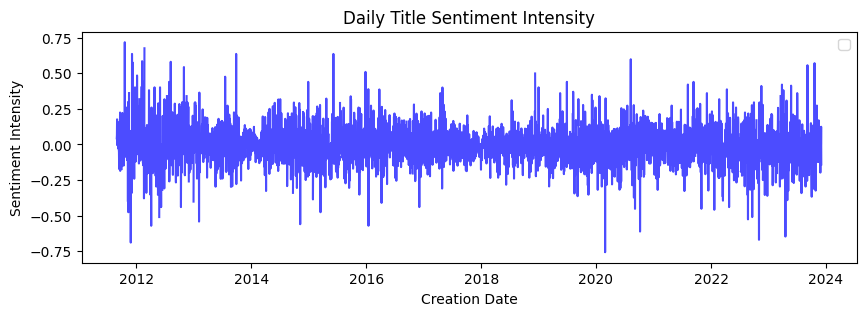

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['title_compound'],
         color='blue', alpha=.7)

plt.title('Daily Title Sentiment Intensity')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Intensity')
plt.legend()
plt.show()

##### Positive vs. Negative Sentiment (for Title)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


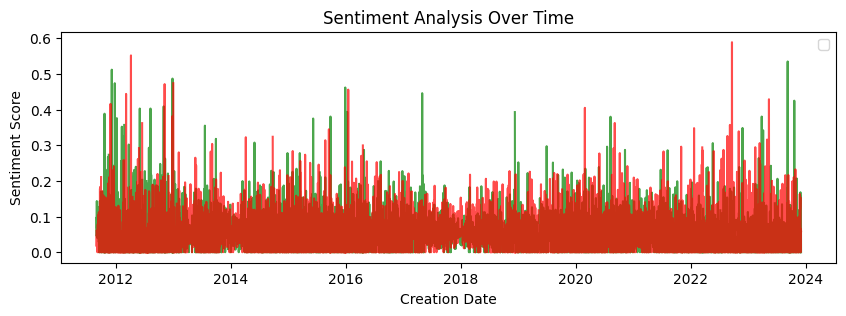

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['title_pos'],
         color='green', alpha=.7)
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['title_neg'],
         color='red', alpha=.7)

plt.title('Sentiment Analysis Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

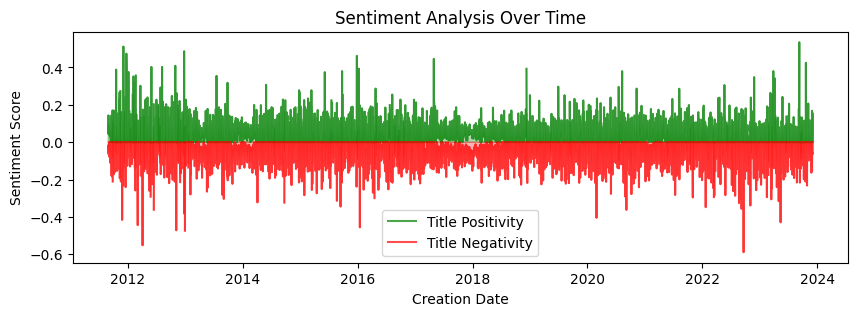

In [15]:
plt.figure(figsize=(10, 3))

# plot positive sentiment above x-axis
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['title_pos'], label='Title Positivity',
         color='green', alpha=.7)

# plot negative sentiment below x-axis
plt.plot(daily_sentiment['CreationDate'], -daily_sentiment['title_neg'], label='Title Negativity',
         color='red', alpha=.7)

# Fill the area between the lines
plt.fill_between(daily_sentiment['CreationDate'], daily_sentiment['title_pos'], color='green', alpha=0.3)
plt.fill_between(daily_sentiment['CreationDate'], -daily_sentiment['title_neg'], color='red', alpha=0.3)

plt.title('Sentiment Analysis Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

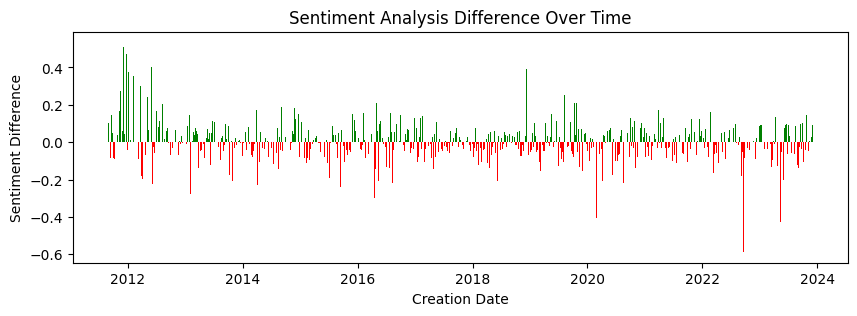

In [16]:
import matplotlib.pyplot as plt

# Calculate the difference between title_pos and title_neg
daily_sentiment['title_difference'] = daily_sentiment['title_pos'] - daily_sentiment['title_neg']

# Plot the bar plot
plt.figure(figsize=(10, 3))
plt.bar(daily_sentiment['CreationDate'], daily_sentiment['title_difference'],
        color=['green' if diff > 0 else 'red' for diff in daily_sentiment['title_difference']])

plt.title('Sentiment Analysis Difference Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Difference')
plt.show()


##### Positive vs. Negative Sentiment (for Body)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


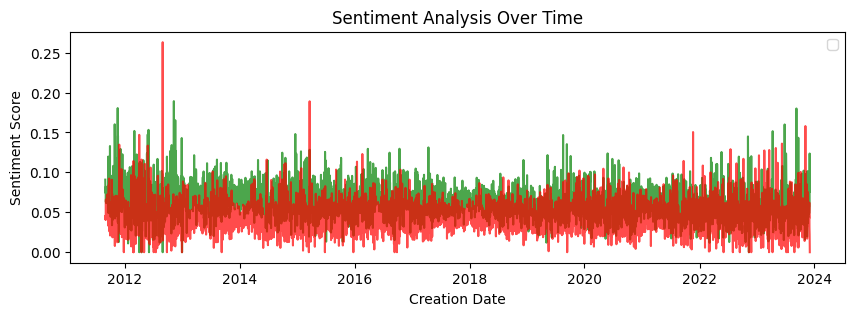

In [17]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['body_pos'],
         color='green', alpha=.7)
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['body_neg'],
         color='red', alpha=.7)

plt.title('Sentiment Analysis Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

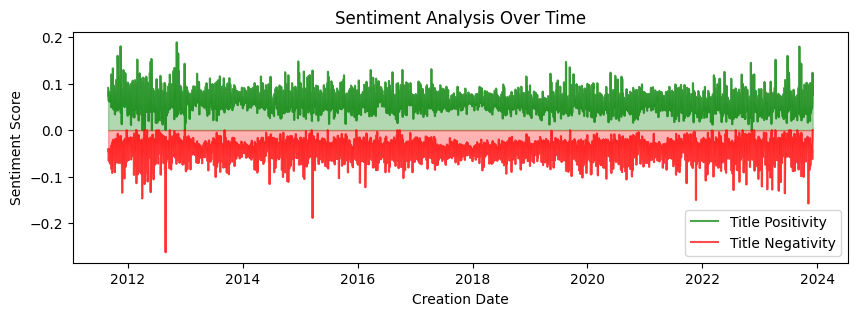

In [18]:
plt.figure(figsize=(10, 3))

# Plot positive sentiment above x-axis
plt.plot(daily_sentiment['CreationDate'], daily_sentiment['body_pos'], label='Title Positivity',
         color='green', alpha=.7)

# Plot negative sentiment below x-axis
plt.plot(daily_sentiment['CreationDate'], -daily_sentiment['body_neg'], label='Title Negativity',
         color='red', alpha=.7)

# Fill the area between the lines and x-axis
plt.fill_between(daily_sentiment['CreationDate'], daily_sentiment['body_pos'], color='green', alpha=0.3)
plt.fill_between(daily_sentiment['CreationDate'], -daily_sentiment['body_neg'], color='red', alpha=0.3)

plt.title('Sentiment Analysis Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

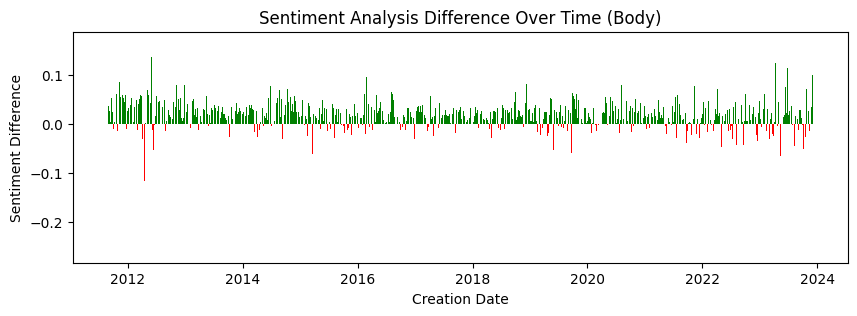

In [19]:
import matplotlib.pyplot as plt

# Calculate the difference between title_pos and title_neg
daily_sentiment['body_difference'] = daily_sentiment['body_pos'] - daily_sentiment['body_neg']

# Plot the bar plot
plt.figure(figsize=(10, 3))
plt.bar(daily_sentiment['CreationDate'], daily_sentiment['body_difference'],
        color=['green' if diff > 0 else 'red' for diff in daily_sentiment['body_difference']])

plt.title('Sentiment Analysis Difference Over Time (Body)')
plt.xlabel('Creation Date')
plt.ylabel('Sentiment Difference')
plt.show()


Tags

In [28]:
df_posts["Tags"]

0        <mining-setup><miner-configuration><mining-sof...
1                            <mining-hardware><gpu-mining>
2                    <mining-reward><mining-profitability>
3                                                     None
4                                                     None
                               ...                        
73908                                        <bip174-psbt>
73909    <bitcoin-core><transactions><satoshi><blocks><...
73910    <multi-signature><bip174-psbt><output-script-d...
73911       <bitcoin-core><bitcoind><bitcoin-cli><custody>
73912                                             <wallet>
Name: Tags, Length: 73913, dtype: object

In [21]:
input_file = "C:\\Users\\barto\\OneDrive\\Dokumenty\\DS2023Z\\DPRP\\CW3\\dprpy_assignment_3\\data\\bitcoin.stackexchange.com-20240119T151759Z-001\\bitcoin.stackexchange.com\Tags.xml"

df_tags = pd.read_xml(input_file)

In [44]:
df_tags.nlargest(150, "Count").iloc[50:100]

Id                   TagName  Count  ExcerptPostId  WikiPostId
54     89                   trading    323          649.0       648.0
328   748        address-generation    323        42533.0     42532.0
186   396                     nodes    316        37713.0     37712.0
22     43                currencies    308         1003.0      1002.0
169   343              buy-bitcoins    305         3819.0      3818.0
406   908                      utxo    292        22271.0     22270.0
323   735  transaction-verification    289        42531.0     42530.0
70    116              cryptography    287         1574.0      1573.0
61    100               doublespend    282          632.0       631.0
481  1092             mnemonic-seed    279        37130.0     37129.0
235   528                wallet.dat    277         8010.0      8009.0
197   425                  multibit    275         8522.0      8521.0
190   411                 hashpower    273        42505.0     42504.0
295   671             exchange-rate    270        18482.0     18481.0
345   785                 consensus    266        54335.0     54334.0
418   952                   mempool    265        57043.0     57042.0
32     58             confirmations    252          968.0       967.0
72    125                   payment    251         1697.0      1696.0
144   275                  bitcoinj    250         2349.0      2348.0
805  1750                   taproot    245       107167.0    107166.0
147   280                     ecdsa    237         3799.0      3798.0
76    132                     fraud    236          949.0       948.0
265   603              coinbase.com    231        13474.0     13473.0
771  1652  lightning-network-daemon    229        74749.0     74748.0
379   855                      p2sh    223        92148.0     92147.0
21     42                      asic    212          628.0       627.0
35     64                     mtgox    207          997.0       996.0
118   221               terminology    207        24273.0     24272.0
327   747              paper-wallet    203        30538.0     30537.0
29     54                     legal    201          653.0       652.0
3       6                    backup    193          622.0       621.0
38     69                    attack    193         1047.0      1046.0
422   966                  ethereum    192        36249.0     36248.0
503  1153      coinbase-transaction    192        35460.0     35459.0
14     30                     linux    184          672.0       671.0
46     80              alternatives    183          600.0       599.0
195   422                      seed    183       100941.0    100940.0
467  1071           wallet-security    182        32036.0     32035.0
226   503                   balance    181        11895.0     11894.0
16     35           economic-theory    179          966.0       965.0
9      18                encryption    174          668.0       667.0
280   644               merkle-tree    172        37715.0     37714.0
299   681                       php    172        59719.0     59718.0
26     48                    ubuntu    171          606.0       605.0
777  1676            core-lightning    171        76488.0     76487.0
117   219                       mac    166         1699.0      1698.0
485  1099                   regtest    163        54714.0     54713.0
541  1218           majority-attack    157        37883.0     37882.0
198   426                    sha256    155         3801.0      3800.0
201   435                   cgminer    148        30534.0     30533.0